In [19]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier

def bagging_fit(X,y, n_estimators, max_depth=5, max_sample=200):
    n_examples = len(y)
    estimators = [DecisionTreeClassifier(max_depth=max_depth) for _ in range(n_estimators)]
    
    for tree in estimators:
        bag = np.random.choice(n_examples, max_sample, replace=True)
        tree.fit(X[bag,:], y[bag])
    return estimators
    

In [24]:
from scipy.stats import mode

def bagging_predict(X, estimators):
    all_predicitons = np.array([tree.predict(X) for tree in estimators])
    y_pred,_ = mode(all_predicitons, axis=0)
    return np.squeeze(y_pred)


In [25]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X,y = make_moons(n_samples=300, noise=0.25, random_state=0)


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33)
bag_ens = bagging_fit(X_train, y_train, n_estimators=500, max_depth=12, max_sample=200)

In [27]:
y_pred = bagging_predict(X_test, bag_ens)
print(accuracy_score(y_test, y_pred))

0.9393939393939394


In [35]:
ensembleAcc = accuracy_score(y_test, y_pred)
print("Bagging holdout accuracy = {0:4.2f}%".format(ensembleAcc*100))

tree = DecisionTreeClassifier(max_depth=12)
y_pred_sigle = tree.fit(X_train, y_train).predict(X_test)
treeAcc = accuracy_score(y_test, y_pred_sigle)
print("Single Decision tree: holdout accuracy = {0:4.2f}%".format(treeAcc*100))

Bagging holdout accuracy = 93.94%
Single Decision tree: holdout accuracy = 90.91%


In [37]:
%%writefile visualization.py

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as col
import numpy as np

from sklearn.datasets import make_moons
from sklearn.svm import SVC


# Get colors from a color map
def get_colors(colormap='viridis', n_colors=2, bounds=(0, 1)):
    cmap = cm.get_cmap(colormap)
    colors_rgb = cmap(np.linspace(bounds[0], bounds[1], num=n_colors))
    colors_hex = [col.rgb2hex(c) for c in colors_rgb]

    return colors_hex


# Plot a 2D classification data set onto the specified axes
def plot_2d_data(ax, X, y, s=20, alpha=0.95, xlabel=None, ylabel=None, title=None, legend=None, colormap='viridis'):
    # Get data set size
    n_examples, n_features = X.shape

    # Check that the data set is 2D
    if n_features != 2:
        raise ValueError('Data set is not 2D!')

    # Check that the lengths of X and y match
    if n_examples != len(y):
        raise ValueError('Length of X is not equal to the length of y!')

    # Get the unique labels and set up marker styles and colors
    unique_labels = np.sort(np.unique(y))
    n_classes = len(unique_labels)

    markers = ['o', 's', '^', 'v', '<', '>', 'p']

    cmap = cm.get_cmap(colormap)
    colors = cmap(np.linspace(0, 1, num=n_classes))

    # Set marker sizes
    if isinstance(s, np.ndarray):
        # If its an ndarray, make sure it has the same size as the number of examples
        if len(s) != n_examples:
            raise ValueError('Length of s is not equal to the length of y!')
    else:
        # Otherwise, make it an nd_array
        s = np.full_like(y, fill_value=s)

    # Plot the data
    for i, label in enumerate(unique_labels):
        marker_color = col.rgb2hex(colors[i])
        marker_shape = markers[i % len(markers)]
        ax.scatter(X[y == label, 0], X[y == label, 1], s=s[y == label],
                   marker=marker_shape, c=marker_color, edgecolors='k', alpha=alpha)

    # Add labels, title and bounds
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=12)
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=12)
    if title is not None:
        ax.set_title(title)

    # Set the legend
    if legend is not None:
        ax.legend(legend)


# Plot a 2D classification function and/or corresponding data set onto the specified axes
def plot_2d_classifier(ax, X, y, predict_function, predict_args=None, predict_proba=False, boundary_level=0.5,
                       s=20, plot_data=True, alpha=0.75,
                       xlabel=None, ylabel=None, title=None, legend=None, colormap='viridis'):

    # Get the bounds of the plot and generate a mesh
    xMin, xMax = X[:, 0].min() - 0.25, X[:, 0].max() + 0.25
    yMin, yMax = X[:, 1].min() - 0.25, X[:, 1].max() + 0.25
    xMesh, yMesh = np.meshgrid(np.arange(xMin, xMax, 0.05),
                               np.arange(yMin, yMax, 0.05))

    # Compute predictions over the mesh
    if predict_proba:
        zMesh = predict_function(np.c_[xMesh.ravel(), yMesh.ravel()])[:, 1]
    elif predict_args is None:
        zMesh = predict_function(np.c_[xMesh.ravel(), yMesh.ravel()])
    else:
        zMesh = predict_function(np.c_[xMesh.ravel(), yMesh.ravel()], predict_args)
    zMesh = zMesh.reshape(xMesh.shape)

    # Plot the classifier
    ax.contourf(xMesh, yMesh, zMesh, cmap=colormap, alpha=alpha, antialiased=True)
    if boundary_level is not None:
        ax.contour(xMesh, yMesh, zMesh, [boundary_level], linewidths=3, colors='k')

    # Plot the data
    if plot_data:
        plot_2d_data(ax, X, y, s=s, xlabel=xlabel, ylabel=ylabel, title=title, legend=legend, colormap=colormap)


if __name__ == '__main__':
    x = get_colors()

    X, y = make_moons(n_samples=100, noise=0.15)
    plt.ion()

    # # Plot data points only
    # fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
    # plot_2d_data(ax, X, y, xlabel='x', ylabel='y', title='Scatter plot test', legend=['pos', 'neg'])
    # fig.tight_layout()

    # Plot a classifier and then superimpose data points
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
    svm = SVC(kernel='rbf', gamma=2.0, probability=True)
    svm.fit(X, y)
    # plot_2d_classifier(ax, X, y, predict_function=svm.predict, predict_args=None)
    plot_2d_classifier(ax, X, y, predict_function=svm.predict_proba, predict_proba=True,
                       xlabel='x', ylabel='y', title='Scatter plot test')

    fig.tight_layout()

    print()

Overwriting visualization.py


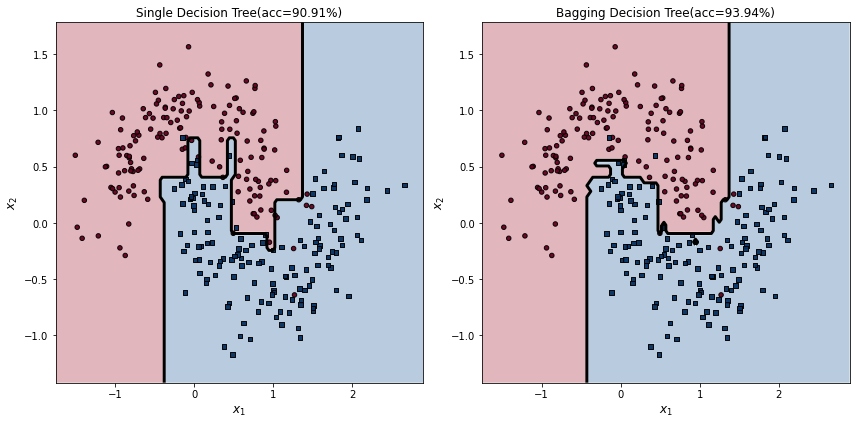

In [41]:
import matplotlib.pyplot as plt
from visualization import plot_2d_classifier

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

title = 'Single Decision Tree(acc={0:4.2f}%)'.format(treeAcc*100)
plot_2d_classifier(ax[0], X, y, colormap='RdBu', alpha=0.3, predict_function=tree.predict,
                  xlabel='$x_1$', ylabel='$x_2$', title=title)

title = 'Bagging Decision Tree(acc={0:4.2f}%)'.format(ensembleAcc*100)
plot_2d_classifier(ax[1], X, y, colormap='RdBu', alpha=0.3, predict_function=bagging_predict, 
                   predict_args=(bag_ens),
                  xlabel='$x_1$', ylabel='$x_2$', title=title)

fig.tight_layout()
plt.show()

In [42]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

base_estimator = DecisionTreeClassifier(max_depth=10)
bag_ens = BaggingClassifier(base_estimator, n_estimators=500, max_samples=100, oob_score=True)

bag_ens.fit(X_train, y_train)
y_pred = bag_ens.predict(X_test)

In [43]:
bag_ens.oob_score_

0.9353233830845771

In [44]:
accuracy_score(y_test, y_pred)

0.9494949494949495